#**№7**
##  Визуализировать эмпирическое распределение параметров модели однослойной нейросети в зависимости от количества нейронов на скрытом слое (рассматривать в том числе и сильно переусложненные модели). Модель: однослойная нейросеть. Выборка: MNIST.




Будем рассматривать нейронную сеть с одним скрытым слоем и выводить распределения весов с первого слоя в зависимости от количества скрытых нейронов 

In [ ]:
!pip install idx2numpy
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz #train images
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz #train labels
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz #test images
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz #test labels





import gzip, idx2numpy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import ipywidgets as widgets
from torch import optim
from torch.utils.data import Dataset, DataLoader
from ipywidgets import interact, interactive, fixed, interact_manual




class ImagesDataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, i):
    return (self.X[i], self.Y[i])


def fit(epochs, lr):
  optimizer.param_groups[0]['lr'] = lr

  for epoch in range(1, epochs+1):
    val_loss = 0
    model.train()
    for batch_index, (x, y) in enumerate(train_loader):
      x, y = x.float().to(device), y.long().to(device)
      optimizer.zero_grad()
      pred = model(x)
      loss = cel(pred, y)
      loss.backward()
      optimizer.step()
    model.eval()
    for batch_index, (x, y) in enumerate(eval_loader):
      x, y = x.float().to(device), y.long().to(device)
      pred = model(x)
      val_loss += cel(pred, y)
    val_loss /= len(eval_loader.dataset)
    # print(f'epoch: {epoch};  loss:{round(loss.item(), 4)}\t val_loss: {val_loss}')



def test_model():
  model.eval()
  for batch_index, (x, y) in enumerate(test_loader):
    x, y = x.float().to(device), y.long().to(device)

    pred = model(x)
    pred = torch.argmax(pred, -1)
    correct = torch.sum(pred==y) 
    pct_correct = correct/torch.tensor(test_loader.batch_size, dtype=torch.float32)
    if 'errors' in locals():
      torch.stack((errors, pct_correct))
    else:
      errors = pct_correct
  return errors.mean().cpu().numpy()*100



def ann_func(hidden):
  cou = 0
  numbers = np.random.randint(low = 0, high = (arr_wei[int(hidden)].shape[0]), size = 16)
  fig, ax = plt.subplots(4, 4, sharex='col', sharey='row', figsize=(14, 14))
  for i in range(4):
    for j in range(4):
        ax[i, j].imshow(arr_wei[int(hidden)][numbers[cou],:].reshape(28, 28),  cmap='Greys')
        cou = cou+ 1
  
  fig.suptitle('Number of hidden neurons: ' + str(hiddens[int(hidden)]) + ' \n Model acc: ' + str(accs[int(hidden)]), fontsize=25)
  # fig.suptitle('fdsfsdf')


class NN(nn.Module):
    def __init__(self, hidden_size):
      super(NN, self).__init__()
      self.hidden_size = hidden_size
      self.l1 = nn.Linear(784, self.hidden_size)
      self.hidden = nn.Linear(self.hidden_size,self.hidden_size)
      self.l2 = nn.Linear(self.hidden_size, 10)

    def forward(self, x):
      x = x.view(-1, 784)

      x = F.relu(self.l1(x))
      x = F.relu(self.hidden(x))
      x = (self.l2(x))
      return F.log_softmax(x, dim=-1)

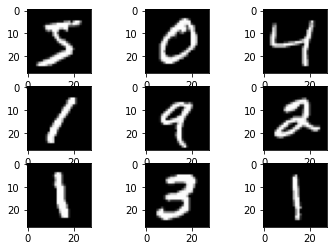

In [5]:
# Данные

images_archive = gzip.open('train-images-idx3-ubyte.gz', 'r')
labels_archive = gzip.open('train-labels-idx1-ubyte.gz', 'r')
test_img_archive = gzip.open('t10k-images-idx3-ubyte.gz', 'r')
test_lbl_archive = gzip.open('t10k-labels-idx1-ubyte.gz', 'r')

images = idx2numpy.convert_from_file(images_archive)
labels = idx2numpy.convert_from_file(labels_archive)
test_images = idx2numpy.convert_from_file(test_img_archive)
test_labels = idx2numpy.convert_from_file(test_lbl_archive)

X_train = images[:48000]
Y_train = labels[:48000]
X_val = images[48000:]
Y_val = labels[48000:]

for i in range(9):
	plt.subplot(330 + 1 + i)
	plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()




In [86]:
train = ImagesDataset(X_train, Y_train)
val = ImagesDataset(X_val, Y_val)
test = ImagesDataset(test_images, test_labels)



# Параметры модели
hiddens = [8,16,32,64,128,256,512,784,1568]
epochs = 25
lr = 1e-4

In [87]:
device = 'cuda'

train_loader = DataLoader(train, batch_size=8192, shuffle=True)
eval_loader = DataLoader(val, batch_size=8192, shuffle=True)
test_loader = DataLoader(test, batch_size=8192)



In [88]:
# Обучение и сохранение весов 
accs = []
arr_wei = []
for hidden_size in hiddens:
  model = NN(hidden_size = hidden_size)
  model.cuda()
  optimizer = optim.Adam(model.parameters())
  cel = nn.CrossEntropyLoss()
  fit(epochs, lr)
  arr_wei.append(model.l1.weight.cpu().detach().numpy())
  accs.append(test_model())

In [89]:
# Визуализация

interact(ann_func,hidden = widgets.FloatSlider(value=4,
                                               min=0,
                                               max=len(hiddens)-1,
                                               step=1))

interactive(children=(FloatSlider(value=4.0, description='hidden', max=8.0, step=1.0), Output()), _dom_classes…

<function __main__.ann_func>

## Из данных распределений что-либо похожее на "причудливые" формы удается разглядеть лишь на графиках с 128, 256 нейронами (округлые или петляющие части) . 
## Более плавные переходы весов можно получить, если увеличить время обучения. В этом случае легче что либо разглядеть:

In [90]:
# Новые параметры

epoch = 100
lr = 5e-4

model = NN(512)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
cel = nn.CrossEntropyLoss()
fit(epoch, lr)
print ('Model acc: ',test_model())

Model acc:  97.0458984375


Text(0.5, 0.98, 'Number of hidden neurons: 512')

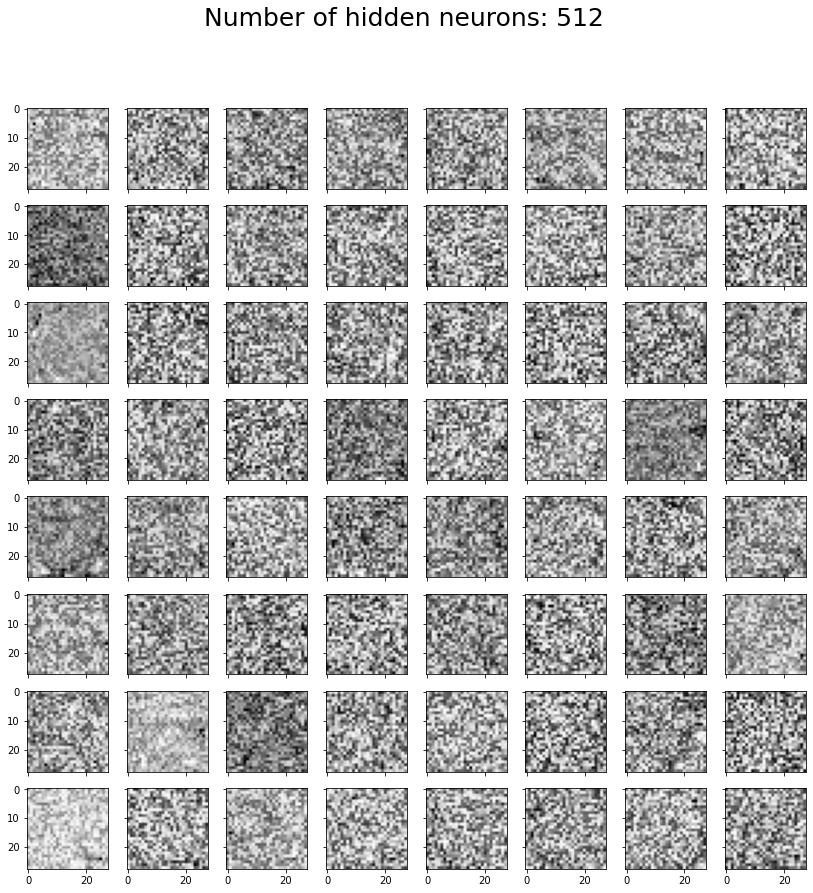

In [91]:

cou = 0
fig, ax = plt.subplots(8, 8, sharex='col', sharey='row', figsize=(14, 14))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(model.l1.weight.cpu().detach().numpy()[cou,:].reshape(28, 28),  cmap='Greys')
        cou = cou+ 1
fig.suptitle('Number of hidden neurons: ' + str(512), fontsize=25)